In [ ]:
!pip install nolds
!pip install hurst

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 2.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy
import statistics
import pywt
from tabulate import tabulate

from numpy.polynomial import Polynomial
from scipy.fft import rfft, rfftfreq
from scipy.interpolate import CubicSpline
import pywt
import nolds

from hurst import compute_Hc, random_walk
import fathon
from neurodsp.aperiodic import compute_fluctuations

1. По массиву кардиоинтервалов провести исследование нелинейной динамики сердечного ритма, рассчитав показатель Херста и показатель флуктуации α. Проанализировать полученные данные.
2. Сравнить полученные значения с реализацией показателей в библиотеке nolds (NOnLinear measures for Dynamical Systems)
https://cschoel.github.io/nolds/nolds.html#hurst-exponent
https://cschoel.github.io/nolds/nolds.html#detrended-fluctuation-analysis

In [ ]:
data = pd.read_csv('Data/2_f_1.csv', names = ['RR'])
RR = data.RR
RR

0       958
1       978
2      1020
3      1062
4      1081
       ... 
295     978
296     929
297     873
298     877
299     958
Name: RR, Length: 300, dtype: int64

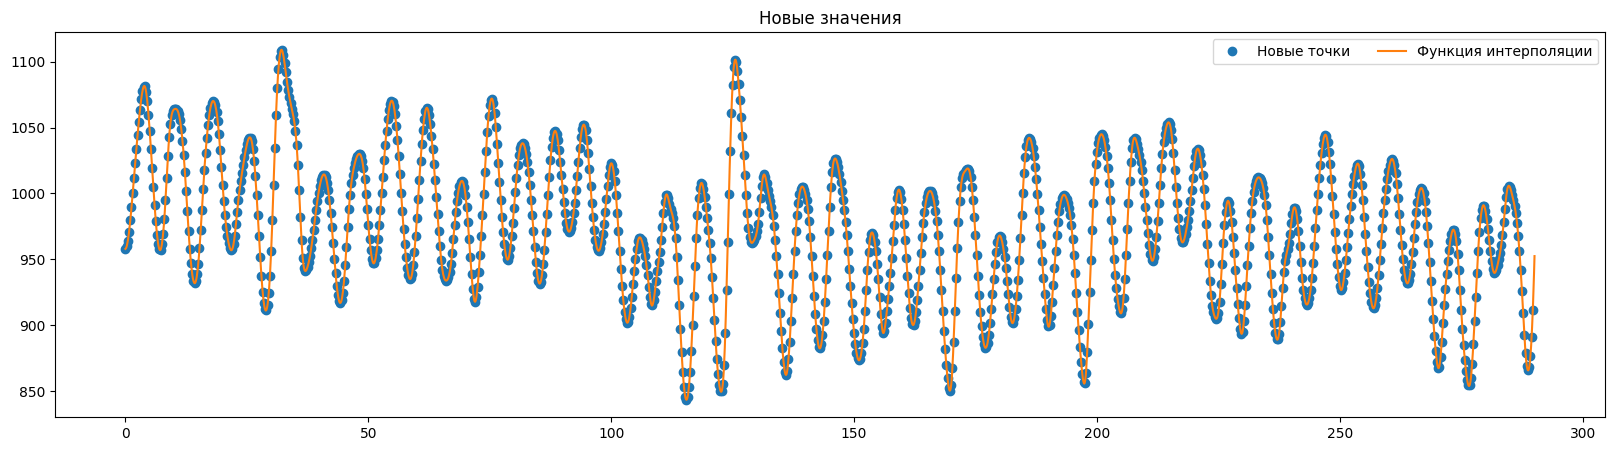

In [ ]:
signal = np.array(RR)
time_x = [0]
for i in range(0,len(signal)-1):
    time_x.append(signal[i]/1000+time_x[i])

cs = CubicSpline(time_x, signal)
xs = np.arange(0, max(time_x), 0.1)

max_time = int(max(time_x))
delta = 0.25
scale = 1/delta
n_batch = int(max_time*scale/2)
time = np.array([float(i)*delta for i in range(int(n_batch*2))])
values = cs(time)
plt.figure(figsize=(20, 5))
plt.title('Новые значения')
plt.plot(time, values, 'o', label="Новые точки")
plt.plot(xs, cs(xs), label="Функция интерполяции")
plt.legend(ncol=2)
plt.show()

In [ ]:
#values = data.RR.tolist()

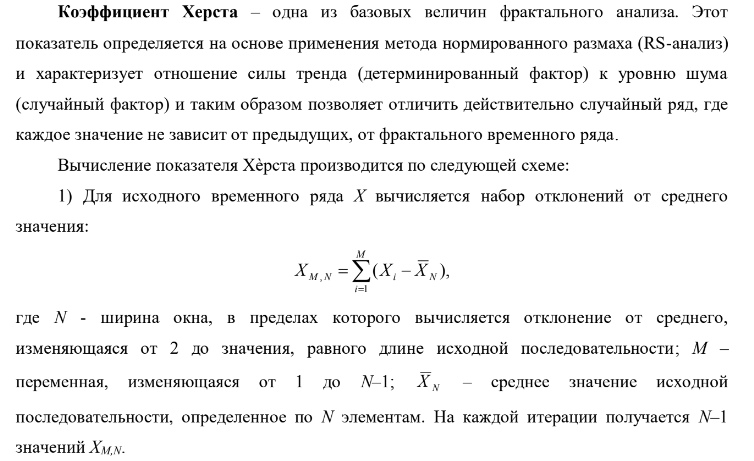

In [ ]:
N = np.array(range(2, len(values)))

Xmn = [[np.sum(np.array(values[:m]) - np.mean(values[:n])) for m in range(n)] for n in N]

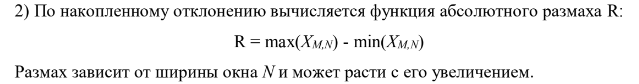

In [ ]:
R = np.array([max(x) - min(x) for x in Xmn])

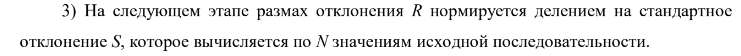

In [ ]:
S = np.array([np.std(values[:n]) for n in N])
norm_R = R / S

image.png

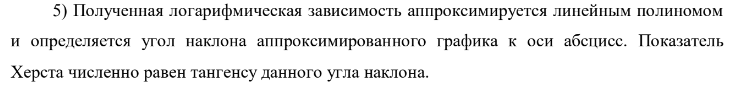

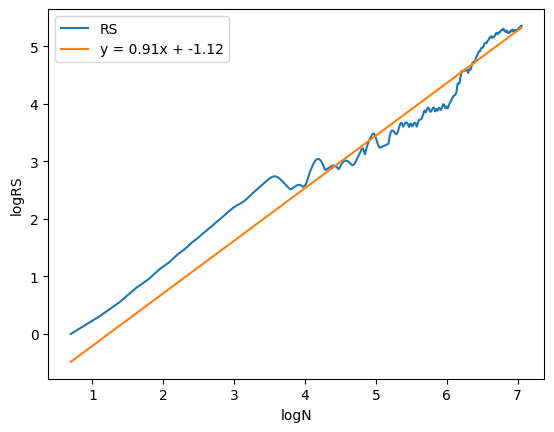

In [ ]:
logRS = np.log(norm_R)
logN = np.log(N)

#k, b = Polynomial.fit(logN, logRS,1)
# угловой коэф. k - тангенс угла наклона
k, b = np.polyfit(logN, logRS, 1)

plt.plot(logN,logRS)
plt.plot([logN[0], logN[-1]], [k * logN[0] + b, k * logN[-1] + b])
plt.ylabel('logRS')
plt.xlabel('logN')
plt.legend(['RS', f'y = {k:.2f}x + {b:.2f}'])
plt.show()

In [ ]:
# Сравнением
print('Самостоятельно рассчитанный коэффициент Херста = ', k)
print('Nolds с коэффициент Аниса-Ллойда-Питерса = ', nolds.hurst_rs(values, corrected=True))
print('Nolds без коэффициент Аниса-Ллойда-Питерса = ', nolds.hurst_rs(values, corrected=False))

# Evaluate Hurst equation
H, c, data = compute_Hc(values, kind='change', simplified=True)
print('Коэффициент через библиотеку hurst = ',H)

Самостоятельно рассчитанный коэффициент Херста =  0.9136495860353461
Nolds с коэффициент Аниса-Ллойда-Питерса =  0.5516990538498437
Nolds без коэффициент Аниса-Ллойда-Питерса =  0.7558298337334658
Коэффициент через библиотеку hurst =  0.8498346872479655


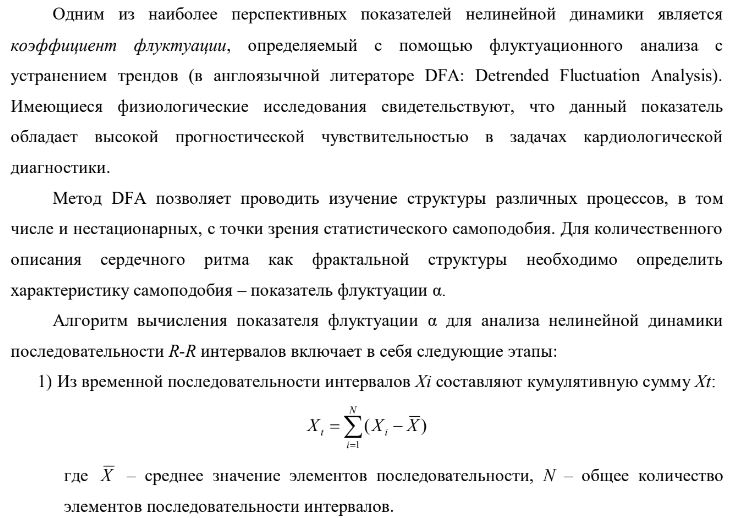

In [ ]:
values = RR
Xt = np.cumsum(values - np.mean(values))

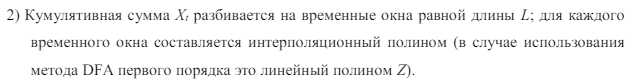

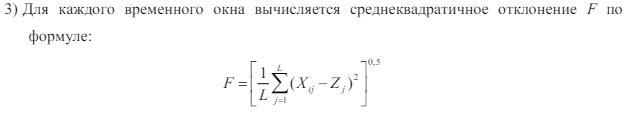

image.png

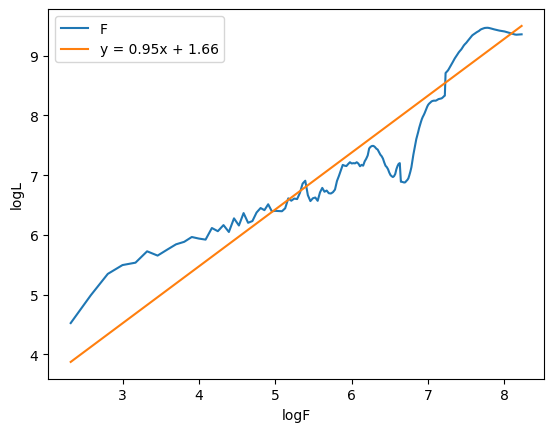

In [ ]:
def STD_F(X,L):
  i = 0
  stds = []
  while i + L < len(X):
    k, b = np.polyfit(range(i, i+L), X[i:i+L], 1)
    Z = np.array([k * x + b for x in range(i, i + L)])
    stds.append(np.sqrt(np.mean((X[i:i+L] - Z)**2)))
    i += L
  return np.mean(stds)

N = len(Xt)
L = list(range(5,N))

F = [STD_F(Xt, l) for l in L]

logF = np.log2(F)
logL = np.log2(L)
k, b = np.polyfit(logL, logF, 1)

plt.plot(logL, logF)
plt.plot([logL[0], logL[-1]], [k * logL[0] + b, k * logL[-1] + b])
plt.ylabel('logL')
plt.xlabel('logF')
plt.legend(['F', f'y = {k:.2f}x + {b:.2f}'])
plt.show()

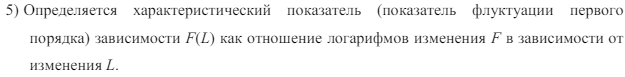

In [ ]:
# Сравнением
print('Самостоятельно рассчитанный коэффициент = ', k)
print('Коэффициент через Nolds = ', nolds.dfa(values))

Самостоятельно рассчитанный коэффициент =  0.9528627582884472
Коэффициент через Nolds =  0.7815323355101833
Коэффициент через библиотеку fathon =  2.878274729480145
